# Exercice on local approximation of an bivariate quadratic expression using linear regression

Idea : 
- Given two features, extract y (the label)
- Perform linear regression analiticaly
- Perform linear regression with gradient descent (SGD)

In [1]:
#%matplotlib notebook
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy as sy
import pandas
# Axes3D necessary for surface plot
from mpl_toolkits.mplot3d import Axes3D

In 2D, it would require many points to uniformly cover the x plan

It is then prefer to draw x points from a 2D uniform distribution

Drawing y as function of $x_0, x_1$ is then more challenging as $x_0$ and $x_1$ are not continuous monotonic vectors

$f(x) = (x_0−0.2)^4 + (x_0−0.1)^3 + 0.1 x_1^2 + 0.35 = x_0^4 + 0.2 x_0^3 − 0.06 x_0^2 − 0.002 x_0 + 0.1 x_1^2 + 0.3506$

In [76]:
#
xMin = np.array([0, -0.5])
xMax = np.array([0.5, 0.5])
# f(x) as a bivariate polynom
fPoly = np.array([[-0.002, 0], [-0.06, 0.1], [0.2, 0], [1, 0]])
#
b = 0.35
std = 0.01
#
def generateBatch(N):
    x = random.uniform(xMin, xMax, (N, 2))
    yClean = (x[:,0]-0.2)**4 + (x[:,0]-0.1)**3 + 0.1*x[:,1]**2 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

In [3]:
N = 100000
x, y, yClean = generateBatch(N);
print('x', x.shape, ', yClean', yClean.shape, ', y', y.shape);

x (100000, 2) , yClean (100000,) , y (100000,)


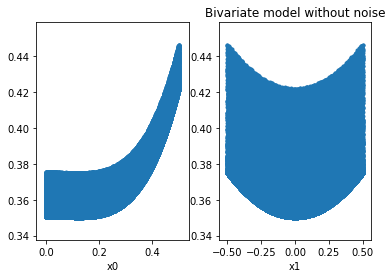

In [4]:
plt.subplot(1,2,1)
plt.scatter(x[:,0], yClean, marker='.');
plt.xlabel('x0')
plt.subplot(1,2,2)
plt.scatter(x[:,1], yClean, marker='.');
plt.xlabel('x1')
plt.title('Bivariate model without noise');

It looks like a tobogan from the side (x0) and from the front (x1)

## Analiticaly / Closed form

Remove biases

In [5]:
xUnB = x - np.mean(x, axis=0)
yUnB = y - np.mean(y)

## Maison

In [6]:
xTxInv = np.linalg.inv(np.matmul(xUnB.T,xUnB))
w = np.matmul(xTxInv,np.matmul(xUnB.T, yUnB))
w

array([ 0.11368446, -0.00037541])

In [7]:
bEst = np.mean(y - np.matmul(x, w))
bEst

0.34377944622447321

In [8]:
yEst1 = np.matmul(x, w) + bEst

mse1 = 0.000257619790786


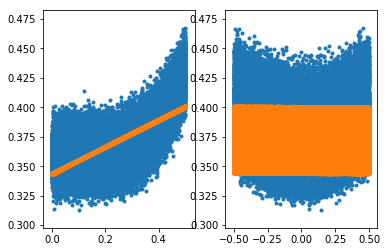

In [9]:
plt.subplot(1,2,1)
plt.scatter(x[:,0], y, marker='.');
plt.scatter(x[:,0], yEst1, marker='.');
plt.subplot(1,2,2)
plt.scatter(x[:,1], y, marker='.');
plt.scatter(x[:,1], yEst1, marker='.');
mse1 = np.dot(y-yEst1, y-yEst1) / N
print('mse1 =', mse1);

The tobogan has been approximated by a plan

## Home made with powers
Adding some flexibility to the model using powers of x

In [10]:
x2 = np.concatenate((x, x**2, x**3, x**4), axis=1)
x2.shape

(100000, 8)

In [11]:
x2UnB = x2 - np.mean(x2, axis=0)

In [12]:
x2Tx2Inv = np.linalg.inv(np.matmul(x2UnB.T,x2UnB))
w2 = np.matmul(x2Tx2Inv,np.matmul(x2UnB.T, yUnB))
w2

array([  8.85664522e-03,  -1.38107384e-04,  -1.44028506e-01,
         1.02693776e-01,   4.37371585e-01,  -1.49676236e-05,
         7.78756153e-01,  -1.23002283e-02])

In [13]:
yEst2 = np.matmul(x2, w2) + bEst

mse2 = 0.000140695811884 , mse2Clean = 4.07931560625e-05


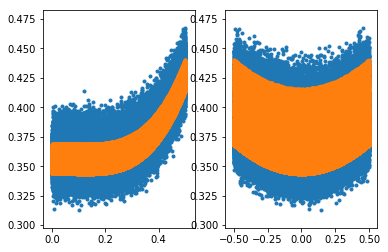

In [14]:
plt.subplot(1,2,1)
plt.scatter(x2[:,0], y, marker='.');
plt.scatter(x2[:,0], yEst2, marker='.');
plt.subplot(1,2,2)
plt.scatter(x2[:,1], y, marker='.');
plt.scatter(x2[:,1], yEst2, marker='.');
mse2 = np.dot(y-yEst2, y-yEst2) / N
mse2Clean = np.dot(yClean-yEst2, yClean-yEst2) / N
print('mse2 =', mse2, ', mse2Clean =', mse2Clean);

The polynomial of y has been well approximated.

The MSE on the noisy sample cannot be lower than the MSE of the noise which is $(10^{-2})^2=10^{-4}$

## NumPy least square

In [15]:
fit4, residues, rank, s = np.linalg.lstsq(xUnB, yUnB)
fit4

array([ 0.11368446, -0.00037541])

In [16]:
yEst4 = np.matmul( x, fit4) + bEst

mse4 = 0.000257619790786


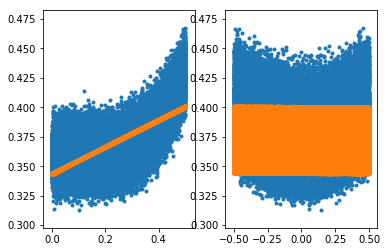

In [17]:
plt.subplot(1,2,1)
plt.scatter(x[:,0], y, marker='.');
plt.scatter(x[:,0], yEst4, marker='.');
plt.subplot(1,2,2)
plt.scatter(x[:,1], y, marker='.');
plt.scatter(x[:,1], yEst4, marker='.');
mse4 = metrics.mean_squared_error(y, yEst4)
print('mse4 =', mse4);

# Gradient descent

Attempt to find a value of w such that the gradient is null (indication of minima, or saddle point)

Loop on the training data until the gradient is below a threshold

In [38]:
w6 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.0001 # Quick
gradient = np.matmul(xUnB.T, np.matmul(xUnB,w6) - yUnB)
gradientNorm = np.sum(gradient**2) # bivariate
print('w start =', w6, ', Gradient norm =', gradientNorm)
w6Learn = [np.concatenate((w6, [gradientNorm]))]
while gradientNorm > threshold:
    w6 = w6 - learningRate * gradient
    gradient = np.matmul(xUnB.T, np.matmul(xUnB,w6) - yUnB)
    gradientNorm = np.sum(gradient**2) # bivariate
    # print('w =', w6, ', Gradient norm =', gradientNorm)
    w6Learn.append(np.concatenate((w6, [gradientNorm])))
print('w end =', w6, ', Gradient norm =', gradientNorm, ', num iteration =', len(w6Learn))
df6 = pandas.DataFrame(w6Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 1840674253.79
w end = [ 0.11368484 -0.00037541] , Gradient norm = 6.31823143329e-07 , num iteration = 71


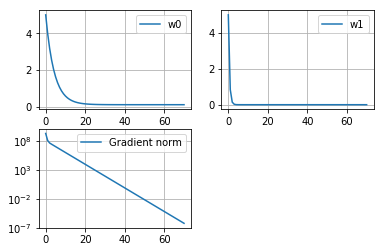

In [52]:
plt.subplot(2,2,1)
plt.plot(df6['w0'])
plt.grid()
plt.legend();
plt.subplot(2,2,2)
plt.plot(df6['w1'])
plt.grid()
plt.legend();
plt.subplot(2,2,3)
plt.semilogy(df6['Gradient norm'])
plt.grid()
plt.legend();

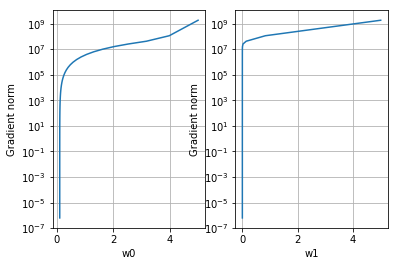

In [20]:
plt.subplot(1,2,1)
plt.semilogy(df6['w0'], df6['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.subplot(1,2,2)
plt.semilogy(df6['w1'], df6['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

In [21]:
yEst6 = np.matmul(x, w6) + bEst

mse6 = 0.000257619790798


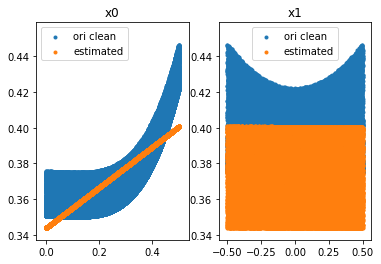

In [22]:
plt.subplot(1,2,1)
plt.scatter(x[:,0], yClean, marker='.')
plt.scatter(x[:,0], yEst6, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(x[:,1], yClean, marker='.')
plt.scatter(x[:,1], yEst6, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse6 = metrics.mean_squared_error(y, yEst6)
print('mse6 =', mse6);

## Stochastic gradient descent

Loop on new data

In [23]:
def calcGradient(x, y, w):
    _x = x - np.mean(x, axis=0)
    _y = y - np.mean(y)
    gradient = np.matmul(_x.T, np.matmul(_x, w) - _y)
    return gradient

In [39]:
Nbatch = 1000
w7 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
gradient = calcGradient(xBatch, yBatch, w7)
gradientNorm = np.sum(gradient**2) 
print('w start =', w7, ', Gradient norm =', gradientNorm)
w7Learn = [np.concatenate((w7, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w7 = w7 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    gradient = calcGradient(xBatch, yBatch, w7)
    gradientNorm = np.sum(gradient**2)
    w7Learn.append(np.concatenate((w7, [gradientNorm])))
    learningRate = learningRate * 0.99
print('w end =', w7, ', Gradient norm =', gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 165014.640419
w end = [ 0.11312349  0.00021313] , Gradient norm = 3.88958950369e-07 , num iteration = 52489


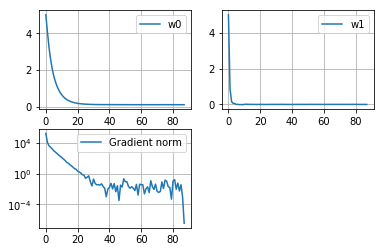

In [25]:
plt.subplot(2,2,1)
plt.plot(df7['w0'])
plt.grid()
plt.legend();
plt.subplot(2,2,2)
plt.plot(df7['w1'])
plt.grid()
plt.legend();
plt.subplot(2,2,3)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.legend();

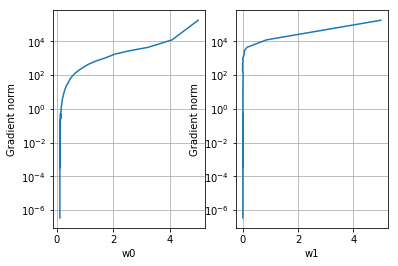

In [26]:
plt.subplot(1,2,1)
plt.semilogy(df7['w0'], df7['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.subplot(1,2,2)
plt.semilogy(df7['w1'], df7['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

In [27]:
yEst7 = np.matmul(x, w7) + bEst

mse7 = 0.000257916326059


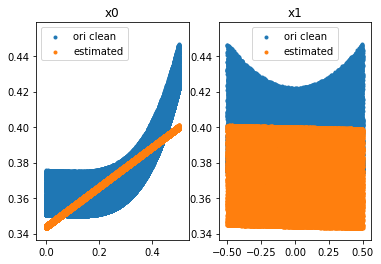

In [28]:
plt.subplot(1,2,1)
plt.scatter(x[:,0], yClean, marker='.')
plt.scatter(x[:,0], yEst7, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(x[:,1], yClean, marker='.')
plt.scatter(x[:,1], yEst7, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse7 = metrics.mean_squared_error(y, yEst7)
print('mse7 =', mse7);

## SGD with powers

Adding powers of x to the stochastic gradient descent

In [40]:
# Batch size
Nbatch = 1000
# Initial coefficient (fixed and tuned manually for this trial)
w8 = np.ones(8)* 1.5 
# Gradient descent end threshold (on the gradient)
threshold = 1e-3
# Initial learning rate
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
gradient = calcGradient(xBatch2, yBatch, w8)
gradientNorm = np.sum(gradient**2) 
print('w start =', w8, ', Gradient norm =', gradientNorm)
# Save the 
w8Learn = [np.concatenate((w8, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w8 = w8 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
    gradient = calcGradient(xBatch2, yBatch, w8)
    gradientNorm = np.sum(gradient**2)
    #print('w =', w8, ', Gradient norm =', gradientNorm)
    w8Learn.append(np.concatenate((w8, [gradientNorm])))
    learningRate = learningRate * 0.999
print('w end =', w8, ', Gradient norm =', gradientNorm, ', num iteration =', len(w8Learn))
df8 = pandas.DataFrame(w8Learn, columns = ('w0_1', 'w1_1', 'w0_2', 'w1_2', 'w0_3', 'w1_3', 'w0_4', 'w1_4', 'Gradient norm'))

w start = [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5] , Gradient norm = 26757.306428
w end = [ 0.01763063 -0.00792599 -0.19023604 -0.10247107  0.43638397  0.0516398
  0.92662281  0.93939378] , Gradient norm = 0.00094205021747 , num iteration = 2412


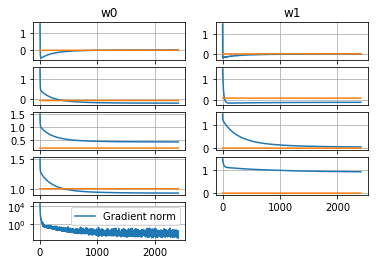

In [78]:
nIter = df8.shape[0]
r = range(nIter)
#
plt.subplot(5,2,1)
plt.plot(r, df8['w0_1'], r, np.ones((nIter))*fPoly[0,0])
plt.grid()
plt.title('w0');
plt.subplot(5,2,2)
plt.plot(r, df8['w1_1'], r, np.ones((nIter))*fPoly[0,1])
plt.grid()
plt.title('w1');
plt.subplot(5,2,3)
plt.plot(r, df8['w0_2'], r, np.ones((nIter))*fPoly[1,0])
plt.grid()
plt.subplot(5,2,4)
plt.plot(r, df8['w1_2'], r, np.ones((nIter))*fPoly[1,1])
plt.grid()
plt.subplot(5,2,5)
plt.plot(r, df8['w0_3'], r, np.ones((nIter))*fPoly[2,0])
plt.grid()
plt.subplot(5,2,6)
plt.plot(r, df8['w1_3'], r, np.ones((nIter))*fPoly[2,1])
plt.grid()
plt.subplot(5,2,7)
plt.plot(r, df8['w0_4'], r, np.ones((nIter))*fPoly[3,0])
plt.grid()
plt.subplot(5,2,8)
plt.plot(r, df8['w1_4'], r, np.ones((nIter))*fPoly[3,1])
plt.grid()
plt.subplot(5,2,9)
plt.semilogy(df8['Gradient norm'])
plt.grid()
plt.legend();

Convergence is not correct on $x_1^4$

In [43]:
yEst8 = np.matmul(x2, w8) + bEst

mse8 = 0.000252136052017


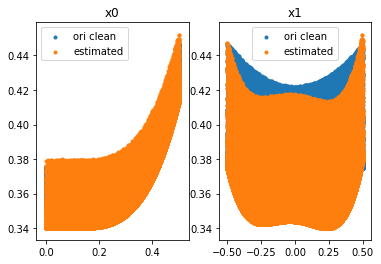

In [44]:
plt.subplot(1,2,1)
plt.scatter(x[:,0], yClean, marker='.')
plt.scatter(x[:,0], yEst8, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(x[:,1], yClean, marker='.')
plt.scatter(x[:,1], yEst8, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse8 = metrics.mean_squared_error(y, yEst8)
print('mse8 =', mse8);

The quadratic terms are not improving the MSE and are making the descent harder to tune